# **Исследование данных HR-агентства**

HR-агентство изучает тренды на рынке труда в *IT*. Компания хочет провести исследование на основе данных о зарплатах в сфере *Data Science* за 2020–2022 годы и получить некоторые выводы.

В процессе анализа мы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:  
2.1 Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?  
2.2 Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?  
2.3 Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?  
2.4 Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [905]:
# Загрузка необходимых библиотек

import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.contingency_tables import mcnemar

In [906]:
data = pd.read_csv('D:/Skillfactory/data/ds_salaries.csv')
display(data.head(11))

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L
6,6,2020,SE,FT,Lead Data Scientist,190000,USD,190000,US,100,US,S
7,7,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
8,8,2020,MI,FT,Business Data Analyst,135000,USD,135000,US,100,US,L
9,9,2020,SE,FT,Lead Data Engineer,125000,USD,125000,NZ,50,NZ,S


## ⭐️ **Подготовка данных: поиск пропусков и дубликатов**

*Проверим общую информацию, посмотрим на тип колонок, nan объекты и пр.*

In [907]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


Пропущенные значения:
Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


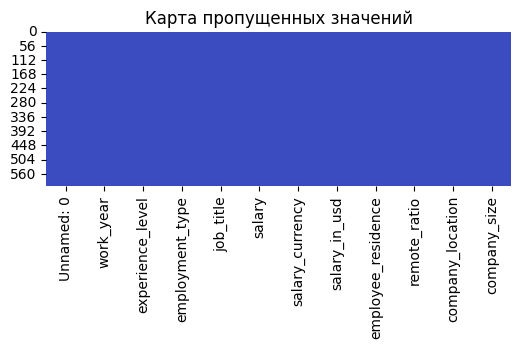

In [908]:
print('Пропущенные значения:')
print(data.isna().sum())

plt.figure(figsize = (6, 2))
sns.heatmap(data.isnull(), cbar = False, cmap = 'coolwarm')
plt.title('Карта пропущенных значений')
plt.show()

*О как, здорово. Датасет содержит в себе 607 записей и не содержит в себе пропущенных значений. Бежим дальше.*   
*Посмотрим есть ли дублирующиеся записи.* 

In [909]:
print(f'Число найденных дубликатов: {data.duplicated().sum()}') 

Число найденных дубликатов: 0


## ⭐️ **Подготовка данных: поиск неинформативных признаков и выбросов**

In [910]:
low_information_cols = [] 

for col in data.columns:
    # наибольшая относительная частота в признаке
    top_freq = data[col].value_counts(normalize=True).max()
    # доля уникальных значений от размера признака
    nunique_ratio = data[col].nunique() / data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

Unnamed: 0: 100.0% уникальных значений
employment_type: 96.87% одинаковых значений


In [911]:
data['employment_type'].value_counts()

employment_type
FT    588
PT     10
CT      5
FL      4
Name: count, dtype: int64

*Изначально столбец **'Unnamed: 0'** мешал обзору на данные таблицы, поэтому его, на самом деле, можно было бы выбросить в самом начале.*  
*Столбец **'employment_type'** можно либо полностью убрать, либо преобразовать его в два значения как: FT - 588, Other - 19. Но проще будет его вообще убрать* 🙂

In [912]:
data = data.drop(['Unnamed: 0', 'employment_type'], axis = 1)

*Идеальных датасетов – редкое количество.*  
*Выберем числовые признаки, по которым могут быть выбросы и визуализируем их*

In [913]:
numeric_cols = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
categorical_cols = ['experience_level', 'job_title', 'salary_currency', 
                    'employee_residence', 'company_location', 'company_size']

print('Числовые колонки')
print(numeric_cols)
print('\nКатегориалные колонки:')
print(categorical_cols)

Числовые колонки
['work_year', 'salary', 'salary_in_usd', 'remote_ratio']

Категориалные колонки:
['experience_level', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']


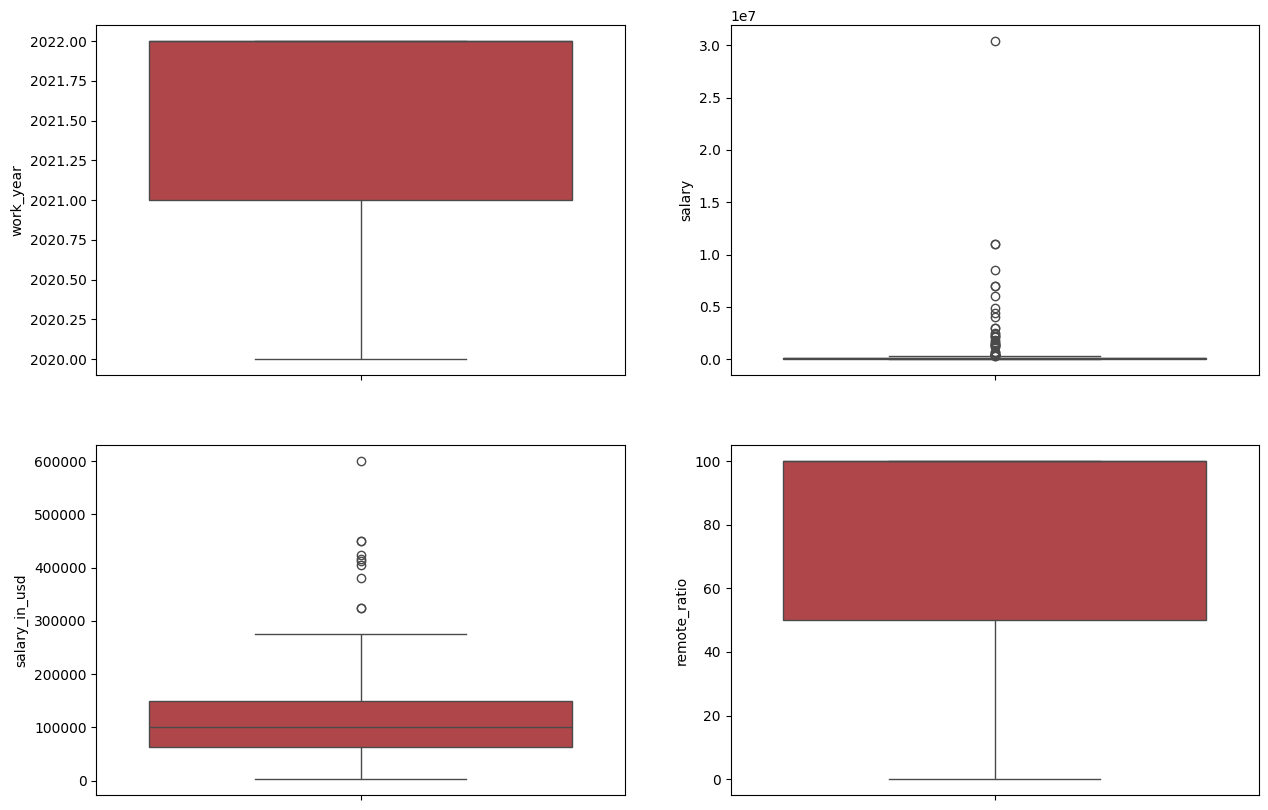

In [914]:
sns.set_palette('RdBu')

fig, axes = plt.subplots(2, 2, figsize = (15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=data[col], ax=axes[i])

*Ну вот, началось.*  
*Наблюдаем очень интересные колонки **'salary'** и **'salary_in_usd'.** Посмотрим на них поближе*

In [915]:
display(data['salary_in_usd'].describe())

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

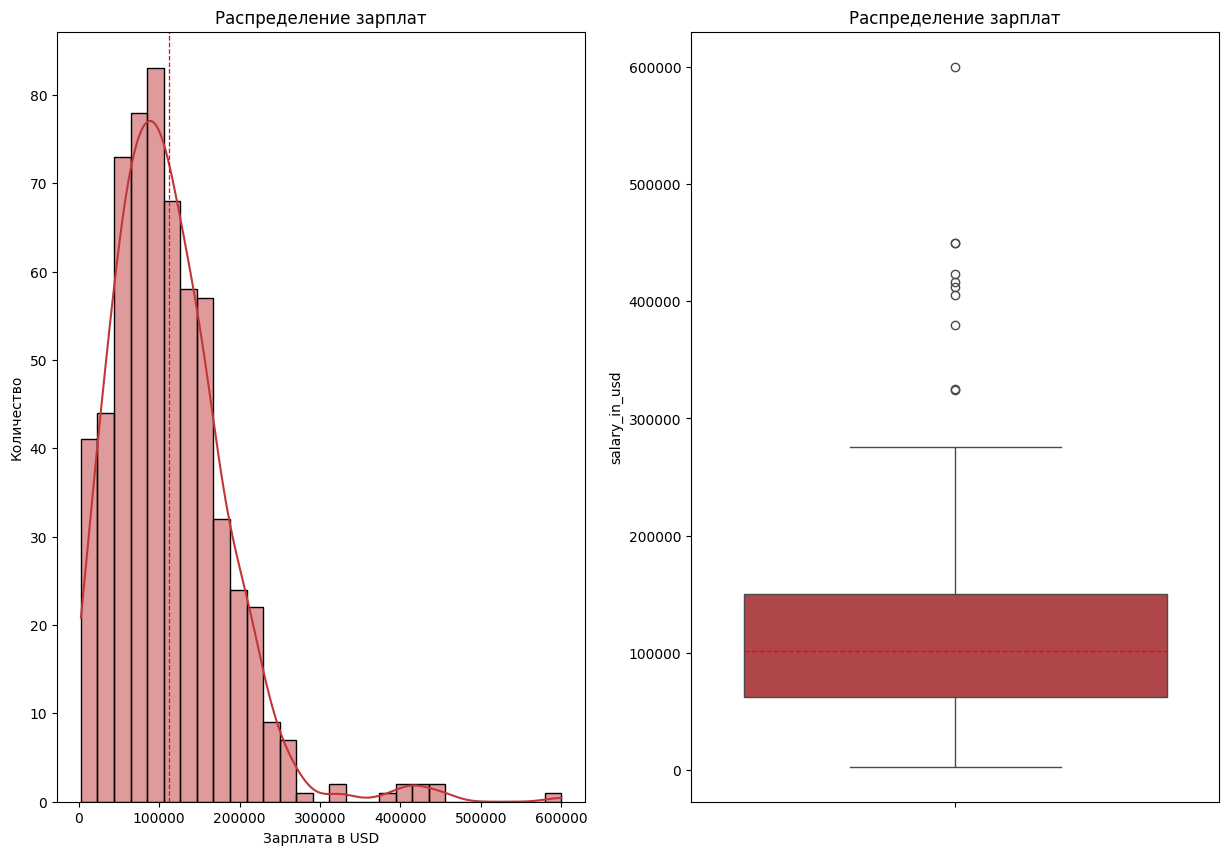

In [916]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в USD', ylabel='Количество')
axes[0].set_title('Распределение зарплат')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.9)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='v', medianprops={"color": "red", "linestyle": '--'})
axes[1].set_title('Распределение зарплат')

plt.show()

*Видим длинный хвост справа который говорит нам, что наше распределение **не является нормальным** из-за супервыбросов по зарплате.*

In [917]:
# числовые колонки для проверки на нормальность
numeric_cols = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']
numeric_data = data[numeric_cols].copy()
display(numeric_data.head())

,work_year,salary,salary_in_usd,remote_ratio
0,2020,70000,79833,0
1,2020,260000,260000,0
2,2020,85000,109024,50
3,2020,20000,20000,0
4,2020,150000,150000,50


In [918]:
alpha = 0.05 

_, p = stats.shapiro(numeric_data)
print('p-value = %.3f' % (p))
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


*Такое значение получилось из-за выбросов по зарплате. Скорее всего, столбец с годом и объёмом работы будут нормальными.*

***Рассмотрим категориальные признаки отдельно:***

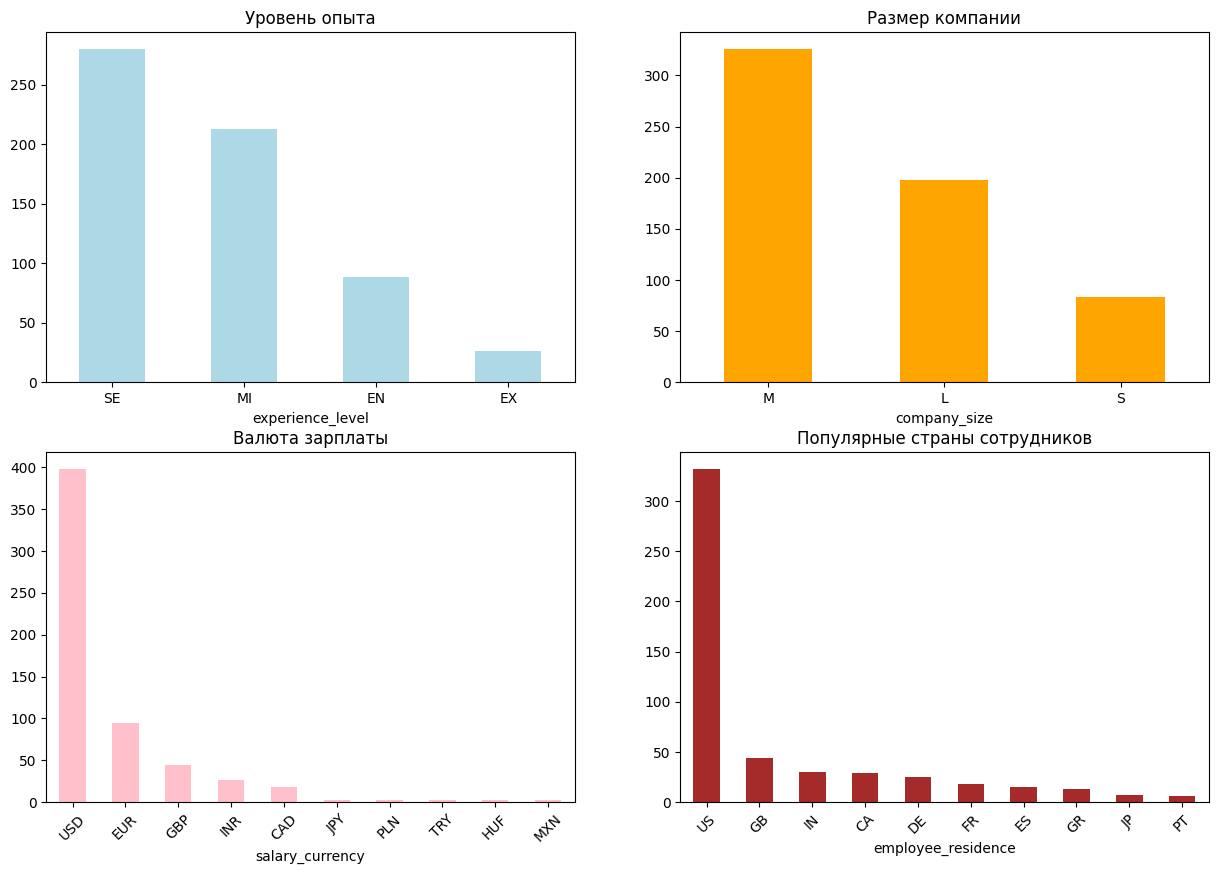

In [919]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
data['experience_level'].value_counts().plot(kind='bar', color='lightblue')
plt.title('Уровень опыта')
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
data['company_size'].value_counts().plot(kind='bar', color='orange')
plt.title('Размер компании')
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
data['salary_currency'].value_counts().head(10).plot(kind='bar', color='pink')
plt.title('Валюта зарплаты')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
data['employee_residence'].value_counts().head(10).plot(kind='bar', color='brown')
plt.title('Популярные страны сотрудников')
plt.xticks(rotation=45);

*По построенным графикам мы можем сделать следующие выводы:*  
- *Большинство сотрудников имеет опыт **Senior** и **Mid-level**.*
- *Компании имеют разный размер, где работают сотрудники.*
- *Оплата труда в большей степени оплачивается в долларах США*
- *Самая популярная страна, где работают сотрудники – США*

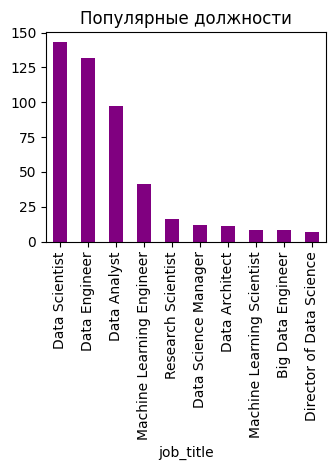

In [920]:
plt.subplot(1, 2, 1)
data['job_title'].value_counts().head(10).plot(kind='bar', color='purple')
plt.title('Популярные должности')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

*На данных гистограммах мы видим, что среди популярных должностей выделяются Data Scientist, Dara Engineer и Data Analyst.*

## ⬇️ **1. Факторы, влияющие на зарплату специалиста Data Scientist**

*Исходя из логики, проверим сочетания:*  
- *уровень опыта/зарплата*
- *размер компании/зарплата*
- *страна/зарплата*

In [921]:
# только для DS
data_ds = data[data['job_title'] == 'Data Scientist']

print(f'Всего записей DS: {len(data_ds)}')

Всего записей DS: 143


Зарплата Data Scientist по уровню опыта:
                  count    median      mean
experience_level                           
SE                   61  140400.0  152971.0
MI                   60   77479.0   82039.0
EN                   22   50484.0   55331.0


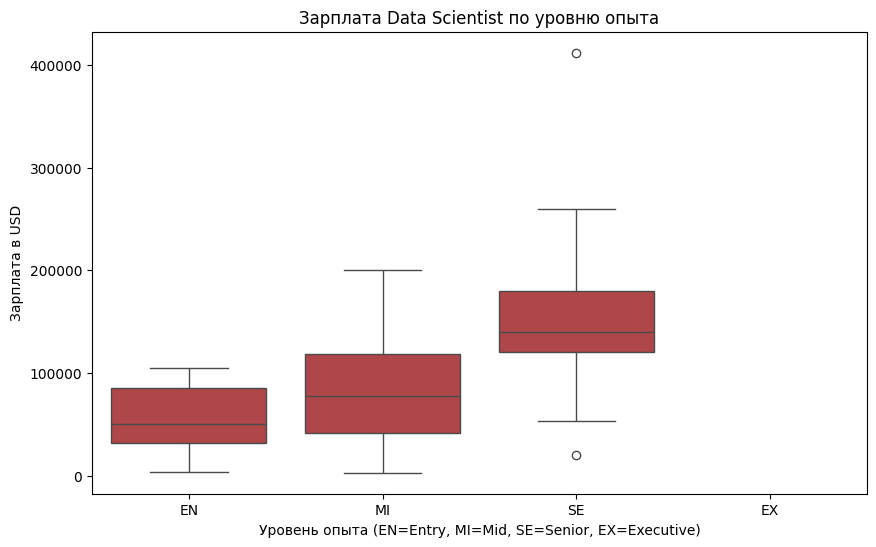

In [922]:
# уровень опыта/зарплата
exp_salary = data_ds.groupby('experience_level')['salary_in_usd'].agg(['count', 'median', 'mean']).round()

print("Зарплата Data Scientist по уровню опыта:")
print(exp_salary.sort_values('median', ascending=False))

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_ds, x='experience_level', y='salary_in_usd', order=['EN', 'MI', 'SE', 'EX'])
plt.title('Зарплата Data Scientist по уровню опыта')
plt.xlabel('Уровень опыта (EN=Entry, MI=Mid, SE=Senior, EX=Executive)')
plt.ylabel('Зарплата в USD')
plt.show()

*Данная коробка сообщает нам печальную новость о том, что в рядах DS нет специалистов Executive-level/Director...✍️*  
*Чем выше опыт работы – тем выше зарплата.*

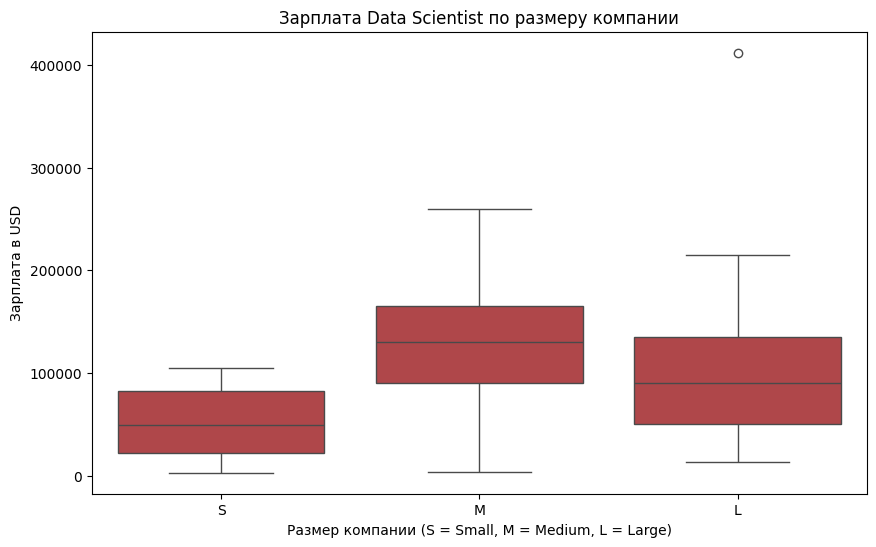

In [923]:
# компания/зарплата
plt.figure(figsize=(10, 6))
sns.boxplot(data = data_ds, x='company_size', y='salary_in_usd', order=['S', 'M', 'L'])
plt.title('Зарплата Data Scientist по размеру компании')
plt.xlabel('Размер компании (S = Small, M = Medium, L = Large)')
plt.ylabel('Зарплата в USD')
plt.show()

*Вероятнее всего, компании размера **М** – устоявшиеся и работают с Мидл и Сеньор специалистами. Крупные компании **L** могут иметь различные стажировки, куда идёт набор и джунов, о чём говорит наличие низких зарплат*

*В L-компании наблюдается крутой выброс по зарплате, рассмотрим подробнее что там.*

In [924]:
outliers_salary = data[data['company_size'] == 'L'].sort_values(by = 'salary_in_usd', ascending=False)
outliers_salary.head(7)

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
252,2021,EX,Principal Data Engineer,600000,USD,600000,US,100,US,L
97,2021,MI,Financial Data Analyst,450000,USD,450000,US,100,US,L
157,2021,MI,Applied Machine Learning Scientist,423000,USD,423000,US,50,US,L
63,2020,SE,Data Scientist,412000,USD,412000,US,100,US,L
523,2022,SE,Data Analytics Lead,405000,USD,405000,US,100,US,L
519,2022,SE,Applied Data Scientist,380000,USD,380000,US,100,US,L
25,2020,EX,Director of Data Science,325000,USD,325000,US,100,US,L


*Очень хочется избавиться от этих крутых и богатых ребят, чтобы не портили нам статистику.*  
*Такие зарплаты – редкость и они мешают всему нашему обзору, мешают считать среднее. Уберём их.*

In [925]:
data = data[(data['company_size'] != 'L') | (data['salary_in_usd'] <= 300000)]

*Восстановим параметры для нового дф*

In [926]:
data_ds = data[data['job_title'] == 'Data Scientist']

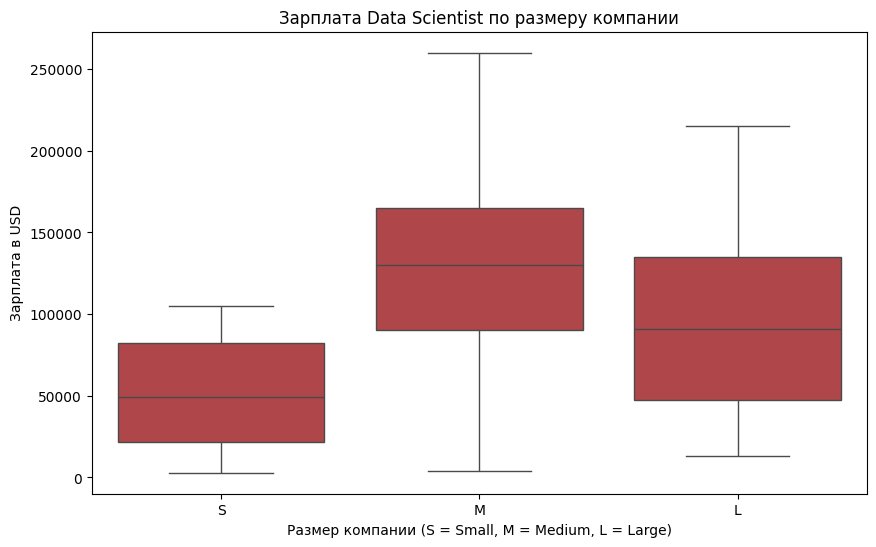

In [927]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = data_ds, x='company_size', y='salary_in_usd', order=['S', 'M', 'L'])
plt.title('Зарплата Data Scientist по размеру компании')
plt.xlabel('Размер компании (S = Small, M = Medium, L = Large)')
plt.ylabel('Зарплата в USD')
plt.show()

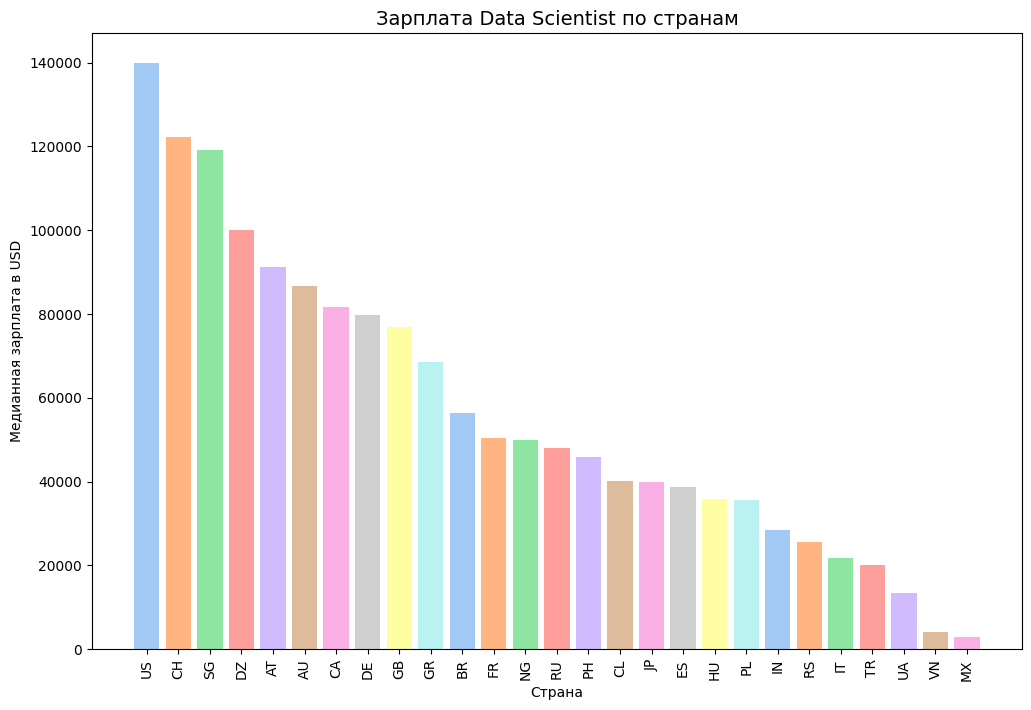

In [928]:
# страна/зарплата
country_avg = data_ds.groupby('employee_residence')['salary_in_usd'].median().round().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors = sns.color_palette("pastel", len(country_avg))
bars = plt.bar(range(len(country_avg)), country_avg.values, color=colors)
plt.title('Зарплата Data Scientist по странам', fontsize=14)
plt.xlabel('Страна')
plt.ylabel('Медианная зарплата в USD')
plt.xticks(range(len(country_avg)), country_avg.index, rotation=90);

*Данный график лишь ещё больше выделяет то, что в США преуспевает везде, как и показывал нам график при рассмотрении категориальных признаков, где США – популярная страна сотрудников. Поспевающий за США Китай – понятное дело.*  
*Нельзя не отметить тот факт, что и Россия находится здесь, на 14 месте, даже обогнав Японию по зарплате. К **моему личному** удивлению, на четвёртом месте – Алжир.*

## ⬇️ **2.1 Наблюдается ли ежегодный рост зарплат у специалистов *Data Scientist*?**

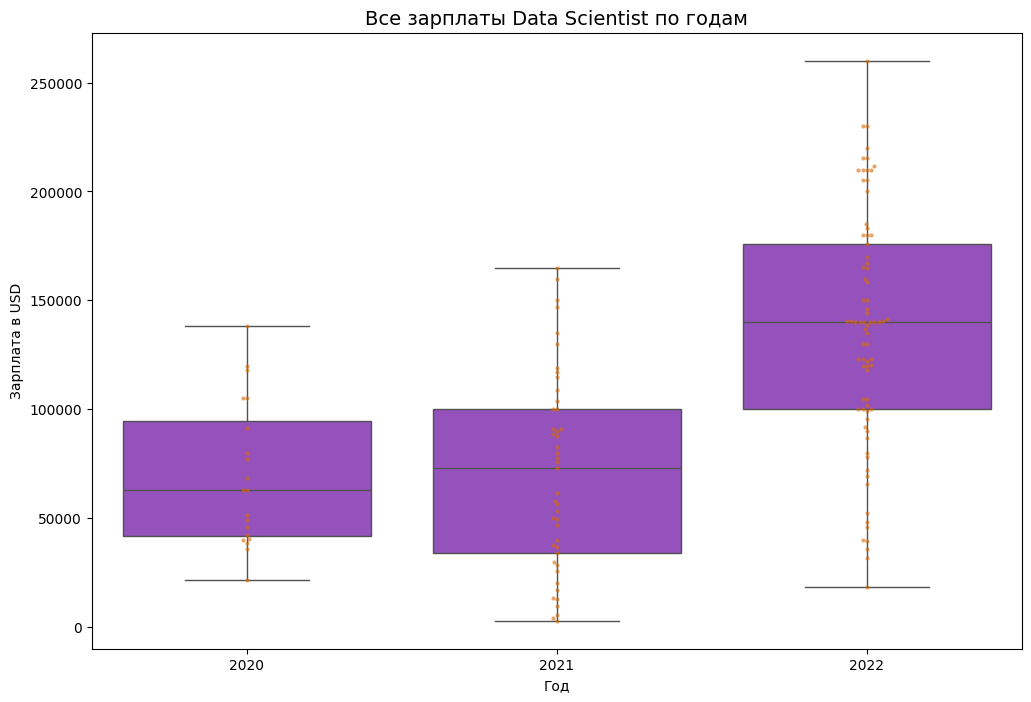

In [929]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_ds, x='work_year', y='salary_in_usd', color="#9A3FCEB2")
sns.swarmplot(data=data_ds, x='work_year', y='salary_in_usd', size=3, alpha=0.6, color="#D86B05")
plt.title('Все зарплаты Data Scientist по годам', fontsize=14)
plt.xlabel('Год')
plt.ylabel('Зарплата в USD')
plt.show()

*Вероятно, влияют разные ситуации на увеличение зарплаты в году. Здесь также играют свою роль экономические и политические проблемы стран.*  
*Зарплата значительно увеличилась в 2022 году относительно 2021 и 2020, но если говорить о е-же-год-ном росте, то выборка из трёх лет – маловата, при наличии данных других годов ответ был бы уверннее.*  
*Тем не менее, есть динамика роста*  

### ⚡ **Статистика к пп. 2.1: ANOVA**

**Сформулируем нулевую и альтернативные гипотезы на вопрос:**  
*Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?*

- *Нулевая гипотеза* (H₀): ежегодный рост зарплат у специалистов *Data Scientist* (μ₁) статистически не увеличивается или равен текущему значению (μ₂).
$$ H₀ : μ₁ ≤ μ₂$$
- *Альтернативная гипотеза* (H₁): ежегодный рост зарплат у специалистов *Data Scientist* (μ₁) статистически увеличивается (μ₂).
$$ H₁ : μ₁ > μ₂$$

In [930]:
salaries_2020 = data_ds[data_ds['work_year'] == 2020]['salary_in_usd']
salaries_2021 = data_ds[data_ds['work_year'] == 2021]['salary_in_usd'] 
salaries_2022 = data_ds[data_ds['work_year'] == 2022]['salary_in_usd']

In [931]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест Левена на равенство дисперсий
print('\n Тест на равенство дисперсий')
result = stats.levene(salaries_2020, salaries_2021, salaries_2022)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else: 
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')

# проводим тест на сравнение средних в группах
print('\n Тест на равенство средних (ANOVA)')
_, p = stats.f_oneway(salaries_2020, salaries_2021, salaries_2022)
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


 Тест на равенство дисперсий
p-value = 0.103
Дисперсии одинаковы, мы можем использовать тест ANOVA

 Тест на равенство средних (ANOVA)
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


*Несмотря на то, что у нас всего три года в выборке, статистический тест ANOVA говорит об увеличении зарплат с скаждым годом. Ну, а со статистикой мы спорить не будем.*

## ⬇️ **2.2 Как соотносятся зарплаты *Data Scientist* и *Data Engineer* в 2022 году?**

In [932]:
# только для DE
data_de = data[data['job_title'] == 'Data Engineer']

print(f'Всего записей DE: {len(data_de)}')

Всего записей DE: 132


In [933]:
# упростим и объединим в один дф
grouped_data = pd.concat([data_ds, data_de])
year_2022 = grouped_data[grouped_data['work_year'] == 2022]

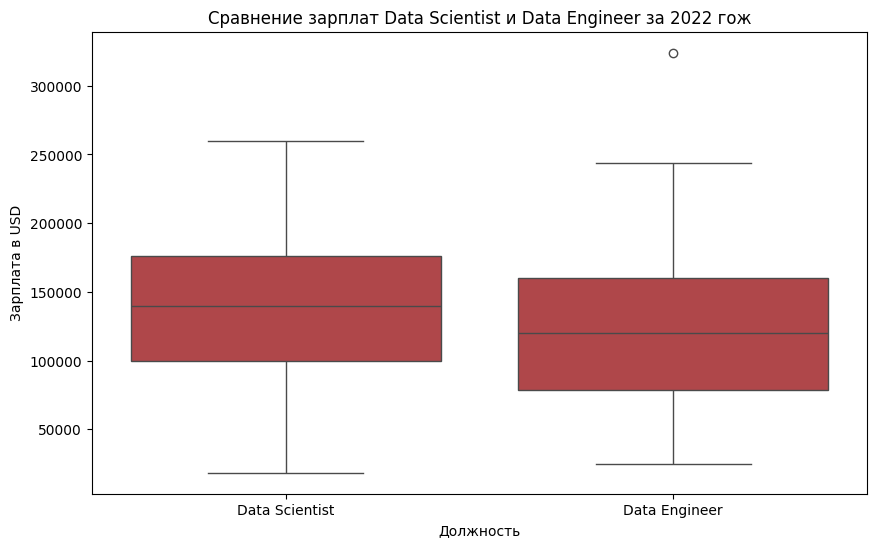

In [934]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=year_2022, x='job_title', y='salary_in_usd')
plt.title('Сравнение зарплат Data Scientist и Data Engineer за 2022 гож')
plt.xlabel('Должность')
plt.ylabel('Зарплата в USD')
plt.show()

*Данный график показывает нам соотношение зарплат специалистов DS и DE. Мы можем увидеть, что специалисты DS получают зарплату выше, чем DE.*

*У инженеров тоже есть крутые ребята с крутой зарплатой, посмотрим на них и удалим выброс.*

In [935]:
outliers_salary_engin = data[data['job_title'] == 'Data Engineer'].sort_values(by = 'salary_in_usd', ascending=False)
outliers_salary_engin.head(3)

,work_year,experience_level,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
482,2022,EX,Data Engineer,324000,USD,324000,US,100,US,M
337,2022,SE,Data Engineer,243900,USD,243900,US,100,US,M
309,2022,EX,Data Engineer,242000,USD,242000,US,100,US,M


*Оказалось, это один такой сотрудник, не страшно его и убрать насовсем из нашей выборки.*

In [936]:
outlier_engin = data[(data['job_title'] == 'Data Engineer') & (data['salary_in_usd'] > 300000)]
print(outlier_engin.index)

data = data.drop(outlier_engin.index)

Index([482], dtype='int64')


In [937]:
# восстанавливаем по-новой параметры
data_de = data[data['job_title'] == 'Data Engineer']

grouped_data = pd.concat([data_ds, data_de])
year_2022 = grouped_data[grouped_data['work_year'] == 2022]

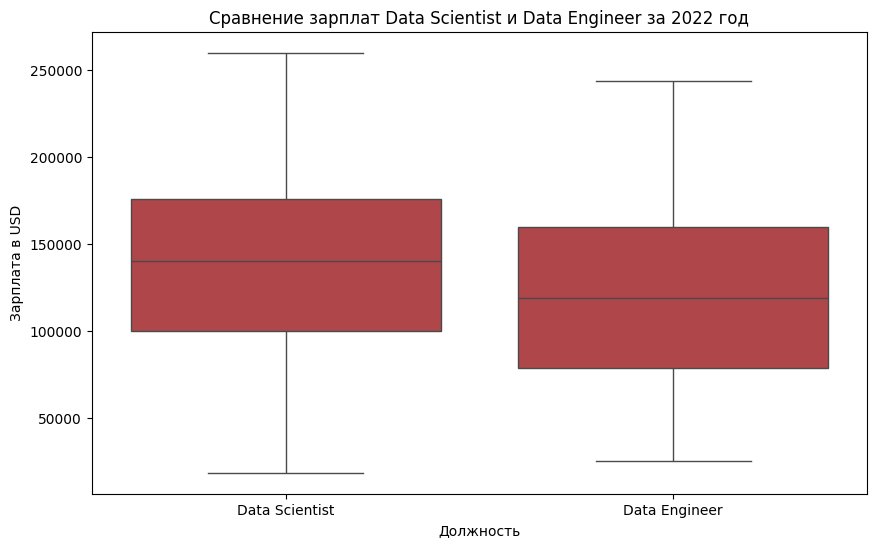

In [938]:
# исправленный вариант зарплат DS и DE
plt.figure(figsize=(10, 6))
sns.boxplot(data=year_2022, x='job_title', y='salary_in_usd')
plt.title('Сравнение зарплат Data Scientist и Data Engineer за 2022 год')
plt.xlabel('Должность')
plt.ylabel('Зарплата в USD')
plt.show()

### ⚡ **Статистика к пп. 2.2: Манн-Уитни**

**Сформулируем нулевую и альтернативные гипотезы на вопрос:**  
*Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?*

- *Нулевая гипотеза* (H₀): зарплаты специалистов *Data Scientist* статистически **не отличаются** от *Data Engineer*.

$$ H₀ : ds = de$$

- *Альтернативная гипотеза* (H₁): зарплаты специалистов *Data Scientist* статистически **отличаются** от *Data Engineer*.

$$ H₁ : ds ≠ de$$

In [939]:
salaries_de = data_de[data_de['work_year'] == 2022]['salary_in_usd'] 
salaries_ds = data_ds[data_ds['work_year'] == 2022]['salary_in_usd']

In [940]:
import scipy.stats as stats

_, p = stats.mannwhitneyu(salaries_ds, salaries_de, alternative='two-sided')
print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.118
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:** мы наблюдаем некоторое противоречие между построенным графиком и статистическим тестом. Можно предположить, что из-за большого диапазона зарплат у специалистов DE и DS (длинные усы на графике) тест Манна-Уитни принял распределение всех значений и "сравнил их" таким образом, что они показались одинаковыми.  
Поэтому, у нас есть основания **отвергнуть** нулевую гипотезу, т.к. зарплаты специалистов отличаются друг от друга.

## ⬇️ **2.3 Как соотносятся зарплаты специалистов *Data Scientist* в компаниях различных размеров?**

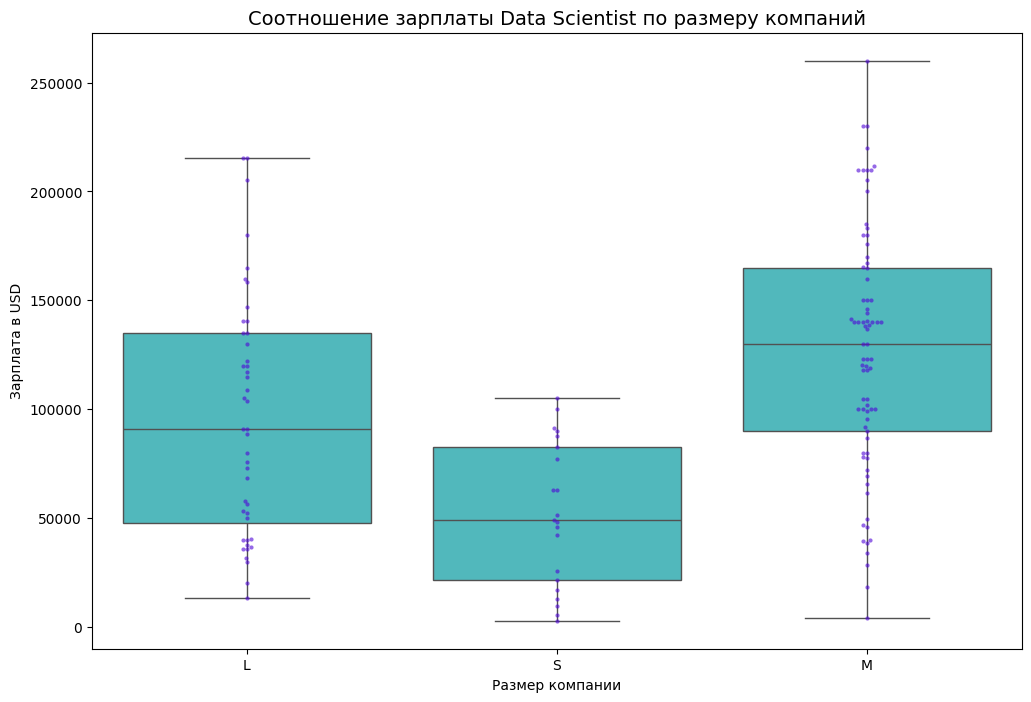

In [941]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_ds, x='company_size', y='salary_in_usd', color="#3FC9CEB1")
sns.swarmplot(data=data_ds, x='company_size', y='salary_in_usd', size=3, alpha=0.6, color="#4F05D8")
plt.title('Соотношение зарплаты Data Scientist по размеру компаний', fontsize=14)
plt.xlabel('Размер компании')
plt.ylabel('Зарплата в USD')
plt.show()

*Интересный разброс размера компаний не по порядку*  
*Компании **М** платят больше, чем **L**. Возможно, есть влияние фактора, который упоминался выше, что "компании **L** могут иметь различные стажировки, куда идёт набор и джунов, о чём говорит наличие низких зарплат".*  
*Также, в крупных компаниях возможны некоторые плюшки, льготы, бонусы, которыми пользуются специалисты.*

### ⚡ **Статистика к пп. 2.3: Краскел-Уоллис**

**Сформулируем нулевую и альтернативные гипотезы на вопрос:**  
*Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?*

- *Нулевая гипотеза* (H₀): зарплаты *Data Scientist* равны во всех LMS (μ₁, μ₂, μ₃) компаниях.

$$ H₀ : μ₁ = μ₂ = μ₃$$

- *Альтернативная гипотеза* (H₁): зарплаты специалистов LMS (μ₁, μ₂, μ₃) компаниях отличаются друг от друга.

$$ H₀ : μ₁ ≠ μ₂ ≠ μ₃$$

In [942]:
company_L = data_ds[data_ds['company_size'] == 'L']['salary_in_usd']
company_M = data_ds[data_ds['company_size'] == 'M']['salary_in_usd'] 
company_S = data_ds[data_ds['company_size'] == 'S']['salary_in_usd']

In [943]:
# проводим тест
_, p = stats.kruskal(company_L, company_M, company_S)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** у нас нет оснований утверждать, что зарплаты специалиста Data Scientist равны в компаниях различных размеров.

## ⬇️ **2.4 Есть ли связь между наличием должностей *Data Scientist* и *Data Engineer* и размером компании?**

In [944]:
ds_count = data[data['job_title'] == 'Data Scientist']['company_size'].value_counts()
ds_count

company_size
M    77
L    44
S    21
Name: count, dtype: int64

In [945]:
de_count = data[data['job_title'] == 'Data Engineer']['company_size'].value_counts()
de_count

company_size
M    88
L    37
S     6
Name: count, dtype: int64

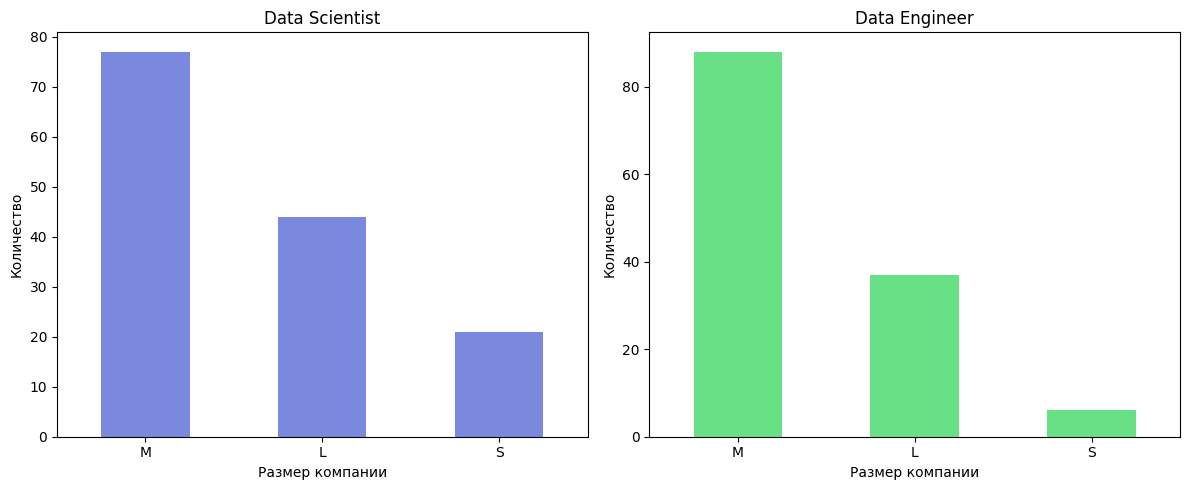

In [946]:
plt.figure(figsize=(12, 5))

# ds
plt.subplot(1, 2, 1)
ds_count.plot(kind='bar', color="#3F54CEB0")
plt.title('Data Scientist')
plt.xlabel('Размер компании')
plt.ylabel('Количество')
plt.xticks(rotation=0)

# de
plt.subplot(1, 2, 2) 
de_count.plot(kind='bar', color="#24D350B0")
plt.title('Data Engineer')
plt.xlabel('Размер компании')
plt.ylabel('Количество')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

*Судя по графикам, можно сделать следующие выводы:*  
- *В **М** компаниях работает больше DE специалистов, чем DS;*
- *В **L** компаниях работает больше DS специалистов;*
- *Очень малое количество DE работает в **S** компаниях.*

*Чем больше компания - тем больше в ней сотрудников, отвечая на вопрос есть ли связь между двумя должностями – да, есть.*

### ⚡ **Статистика к пп. 2.4: Хи-квадрат**

**Сформулируем нулевую и альтернативные гипотезы на вопрос:**  
*Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?*

- *Нулевая гипотеза*: связь между наличием должностей *DS* и *DE*, и размером компании **отсуствует**.

- *Альтернативная гипотеза*: связь между наличием должностей *DS* и *DE*, и размером компании **присутствует**.

In [947]:
filtered_data = data[data['job_title'].isin(['Data Scientist', 'Data Engineer'])]

# вычисляем таблицу сопряжённости
table = pd.crosstab(filtered_data['job_title'], filtered_data['company_size'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.010
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** у нас есть основания утверждать, что должности Data Scientist и Data Engineer взаимосвязаны ввиду размера компаний

## <center> 🔥 **Дополнительно**

### ⚡ **БИЗНЕС-ГИПОТЕЗА №1 ⤵**  

**Действительно ли общий объём работы выполняется только на рабочем месте?**


⇨ Сформулируем нулевую и альтернативные гипотезы:
- *Нулевая гипотеза* (H₀): общий объём работы выполняется только на рабочем месте
$$ H₀ : m = 0$$
- *Альтернативная гипотеза* (H₁): общий объём работы выполняется **не** только на рабочем месте.
$$ H₁ : m ≠ 0$$

Применяем *Одновыборочный t-тест*

In [948]:
work_space = data['remote_ratio']

In [949]:
_, p, = stats.ttest_1samp(work_space, popmean=0)

print('p-value = {:.3f}'.format(p))
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** у нас нет оснований утверждать, что сотрудники работают только на рабочем месте.

### ⚡ **БИЗНЕС-ГИПОТЕЗА №2 ⤵**  

**Влияет ли роль *любого* соискателя на сумму заработной платы?**

⇨ Сформулируем *нулевую* и *альтернативные* гипотезы:
- *Нулевая гипотеза* (H₀): должность (роль) соискателя не влияет на сумму заработной платы, все зарплаты равны.
$$ H₀ : DS = DE = DA = MLE = RS = DSM = MLS$$
- *Альтернативная гипотеза* (H₁): должность (роль) соискателя влияет на сумму заработной платы, хотя бы две пары должностей отличаются.
$$ H₁ : DS ≠ DE ≠ DA ≠ MLE ≠ RS ≠ DSM ≠ MLS$$

Применяем Критерий Краскела-Уоллиса.  
Выберем группу нескольких популярных должностей, которые показываются нам на графике с визуализацией распределения категориальных признаков.  

In [950]:
ds_salaries = data[data['job_title'] == 'Data Scientist']['salary_in_usd']
de_salaries = data[data['job_title'] == 'Data Engineer']['salary_in_usd']  
da_salaries = data[data['job_title'] == 'Data Analyst']['salary_in_usd']
mle_salaries = data[data['job_title'] == 'Machine Learning Engineer']['salary_in_usd']
rs_salaries = data[data['job_title'] == 'Research Scientist']['salary_in_usd']
dsm_salaries = data[data['job_title'] == 'Data Science Manager']['salary_in_usd']
mls_salaries = data[data['job_title'] == 'Machine Learning Scientist']['salary_in_usd']

In [951]:
_, p = stats.kruskal(ds_salaries, de_salaries, da_salaries, mle_salaries, rs_salaries, dsm_salaries, mls_salaries)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.002
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод:** у нас нет оснований утверждать, что все зарплаты равны, у каждых пар зарплаты отличаются друг от друга.

## <center> **Итоговые результаты исследования**

1. **Факторы, влияющие на зарплату специалиста DS:**  
1.1 Опыт работы. Чем выше опыт работы, тем выше зарплата.  
1.2 Размер компании. S – маленькие компании, соответственно и низкая зарплата. M – устоявшиеся и работают с Мидл и Сеньор специалистами. L – могут иметь различные стажировки, куда идёт набор и джунов, о чём говорит наличие как высоких, так и низких зарплат.  
1.3 Страна также влияет на зарплату. США, Китай, Сингапур, страны Европы – индустриальные страны, там зарплаты выше. Но есть и "выбросы", например, Алжир (развивающаяся страна). Там также высокая зарплата для специалиста DS.   

2. **Вопросы HR-агентства:**  
2.1 Статистический тест ANOVA говорит об увеличении зарплат с каждым годом.  
2.2 Специалисты DS получают зарплату выше, чем DE.  
2.3 Компании М платят больше, чем L. Возможно, есть влияние фактора, который упоминался выше, что *компании L могут иметь различные стажировки, куда идёт набор и джунов, о чём говорит наличие низких зарплат*.  
2.4 Чем больше компания – тем больше в ней сотрудников. Специалисты DS и DE обязательно нужны в "связке" в средний и крупных компаниях.  
